# Downloading Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings # tf needs to learn to stfu
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [ ]:
!pip install plotly

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd

import io
import os
import tensorflow as tf

from PIL import Image
from glob import glob
import itertools

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from IPython.display import display
#To see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import cv2

# Read the Data

In [ ]:
base_skin_dir = os.path.join('..', 'input')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir,"/content/drive/MyDrive/Final_Project/archive/HAM10000_images/*.jpg"))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [ ]:
data = pd.read_csv(os.path.join(base_skin_dir,"/content/drive/MyDrive/Final_Project/archive/HAM10000_images/",'/content/drive/MyDrive/Final_Project/archive/HAM10000_metadata.csv'))

In [ ]:
# Now lets see the sample of tile_df to look on newly made columns
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
data.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization
count,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15
top,HAM_0003789,ISIC_0027419,nv,histo,male,back
freq,6,1,6705,5340,5406,2192


In [ ]:
data.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

# Imputing Null Values and Preparing the Data

In [ ]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')

In [ ]:
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [ ]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Final_Project/archive/H...
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Final_Project/archive/H...
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Final_Project/archive/H...
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Final_Project/archive/H...
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Final_Project/archive/H...


In [ ]:
# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

In [ ]:
data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Final_Project/archive/H...,"[[[192, 153, 193], [195, 155, 192], [197, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Final_Project/archive/H...,"[[[27, 16, 32], [69, 49, 76], [122, 93, 126], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Final_Project/archive/H...,"[[[192, 138, 153], [200, 144, 162], [202, 142,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Final_Project/archive/H...,"[[[40, 21, 31], [95, 61, 73], [143, 102, 118],..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Final_Project/archive/H...,"[[[159, 114, 140], [194, 144, 173], [215, 162,..."


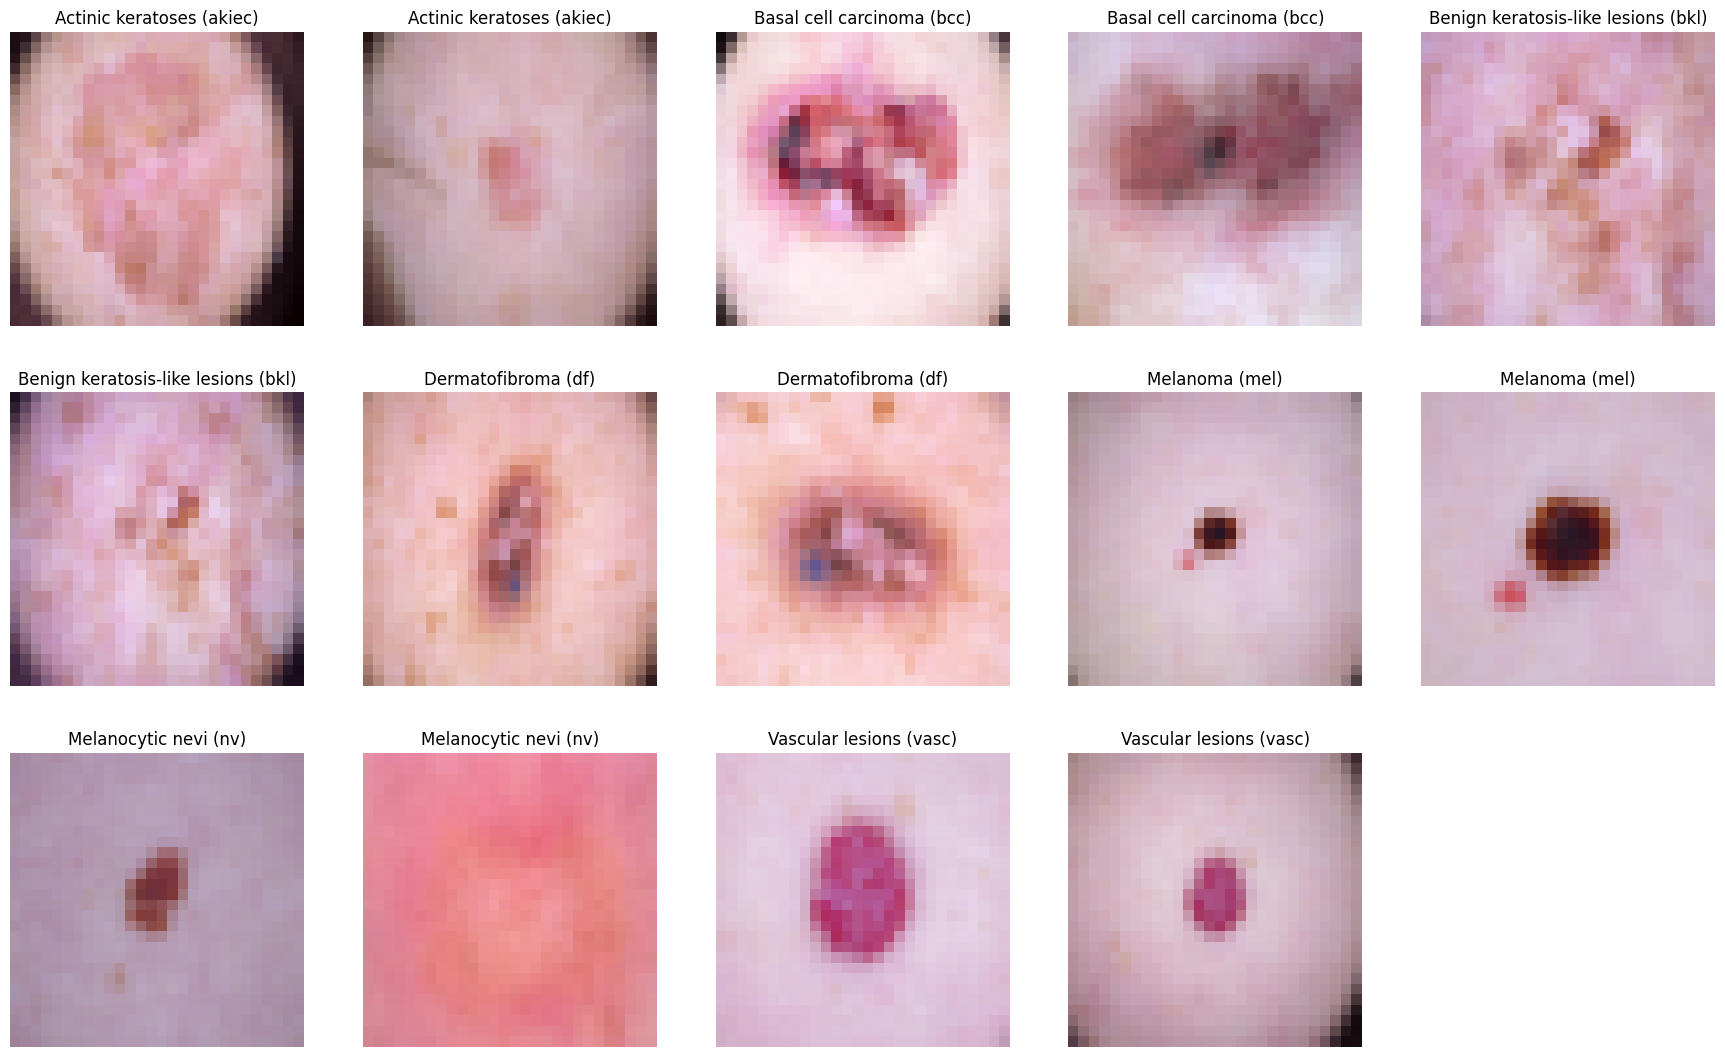

In [ ]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show();

In [ ]:
data['label'] = data['dx'].map(reverse_label_mapping.get)

data = data.sort_values('label')
data = data.reset_index()

In [ ]:
counter = 0
frames = [data]
for i in [4,4,11,17,45,52]:
    counter+=1
    index = data[data['label'] == counter].index.values
    df_index = data.iloc[int(min(index)):int(max(index)+1)]
    df_index = df_index.append([df_index]*i, ignore_index = True)
    frames.append(df_index)


In [ ]:
len(frames)

7

In [ ]:
final_data = pd.concat(frames)

In [ ]:
print(data.shape)
print(final_data.shape)

(10015, 12)
(45756, 12)


In [ ]:
sc_cat = ['Benign keratosis-like lesions (bkl)', 'Melanocytic nevi (nv)', 'Dermatofibroma (df)', 'Melanoma (mel)', 'Vascular lesions (vasc)', 'Basal cell carcinoma (bcc)', 'Actinic keratoses (akiec)']
sc_lid = {'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}
data['l_id'] = data['dx'].map(sc_lid)

# Data Visualization

In [ ]:
df = data
df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label,l_id
0,5007,HAM_0006322,ISIC_0030309,nv,follow_up,55,male,foot,Melanocytic nevi (nv),/content/drive/MyDrive/Final_Project/archive/H...,"[[[237, 159, 171], [238, 158, 173], [241, 161,...",0,1
1,4478,HAM_0003084,ISIC_0026191,nv,follow_up,45,female,upper extremity,Melanocytic nevi (nv),/content/drive/MyDrive/Final_Project/archive/H...,"[[[219, 112, 131], [223, 119, 136], [224, 121,...",0,1
2,4477,HAM_0002093,ISIC_0027032,nv,follow_up,45,female,back,Melanocytic nevi (nv),/content/drive/MyDrive/Final_Project/archive/H...,"[[[234, 134, 155], [238, 140, 164], [234, 130,...",0,1
3,4476,HAM_0003701,ISIC_0027191,nv,follow_up,45,female,lower extremity,Melanocytic nevi (nv),/content/drive/MyDrive/Final_Project/archive/H...,"[[[214, 121, 154], [216, 124, 159], [218, 124,...",0,1
4,4475,HAM_0003806,ISIC_0028667,nv,follow_up,45,female,lower extremity,Melanocytic nevi (nv),/content/drive/MyDrive/Final_Project/archive/H...,"[[[234, 146, 167], [236, 149, 171], [233, 149,...",0,1


In [ ]:
df.tail()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label,l_id
10010,1175,HAM_0003597,ISIC_0033422,df,consensus,45,male,lower extremity,Dermatofibroma (df),/content/drive/MyDrive/Final_Project/archive/H...,"[[[148, 137, 148], [158, 148, 159], [162, 153,...",6,2
10011,1176,HAM_0003597,ISIC_0027488,df,consensus,45,male,lower extremity,Dermatofibroma (df),/content/drive/MyDrive/Final_Project/archive/H...,"[[[191, 187, 200], [194, 190, 202], [192, 187,...",6,2
10012,1177,HAM_0003081,ISIC_0033808,df,consensus,45,male,abdomen,Dermatofibroma (df),/content/drive/MyDrive/Final_Project/archive/H...,"[[[179, 160, 194], [182, 162, 199], [188, 169,...",6,2
10013,1179,HAM_0003081,ISIC_0033860,df,consensus,45,male,abdomen,Dermatofibroma (df),/content/drive/MyDrive/Final_Project/archive/H...,"[[[16, 12, 17], [57, 47, 61], [111, 96, 116], ...",6,2
10014,1123,HAM_0004317,ISIC_0025504,df,histo,50,female,lower extremity,Dermatofibroma (df),/content/drive/MyDrive/Final_Project/archive/H...,"[[[205, 185, 187], [207, 186, 187], [213, 192,...",6,2


In [ ]:
sc_cat = ['Benign keratosis-like lesions (bkl)', 'Melanocytic nevi (nv)', 'Dermatofibroma (df)', 'Melanoma (mel)', 'Vascular lesions (vasc)', 'Basal cell carcinoma (bcc)', 'Actinic keratoses (akiec)']
sc_lid = {'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}
df['l_id'] = df['dx'].map(sc_lid)

In [ ]:
df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label,l_id
0,5007,HAM_0006322,ISIC_0030309,nv,follow_up,55,male,foot,Melanocytic nevi (nv),/content/drive/MyDrive/Final_Project/archive/H...,"[[[237, 159, 171], [238, 158, 173], [241, 161,...",0,1
1,4478,HAM_0003084,ISIC_0026191,nv,follow_up,45,female,upper extremity,Melanocytic nevi (nv),/content/drive/MyDrive/Final_Project/archive/H...,"[[[219, 112, 131], [223, 119, 136], [224, 121,...",0,1
2,4477,HAM_0002093,ISIC_0027032,nv,follow_up,45,female,back,Melanocytic nevi (nv),/content/drive/MyDrive/Final_Project/archive/H...,"[[[234, 134, 155], [238, 140, 164], [234, 130,...",0,1
3,4476,HAM_0003701,ISIC_0027191,nv,follow_up,45,female,lower extremity,Melanocytic nevi (nv),/content/drive/MyDrive/Final_Project/archive/H...,"[[[214, 121, 154], [216, 124, 159], [218, 124,...",0,1
4,4475,HAM_0003806,ISIC_0028667,nv,follow_up,45,female,lower extremity,Melanocytic nevi (nv),/content/drive/MyDrive/Final_Project/archive/H...,"[[[234, 146, 167], [236, 149, 171], [233, 149,...",0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         10015 non-null  int64 
 1   lesion_id     10015 non-null  object
 2   image_id      10015 non-null  object
 3   dx            10015 non-null  object
 4   dx_type       10015 non-null  object
 5   age           10015 non-null  int32 
 6   sex           10015 non-null  object
 7   localization  10015 non-null  object
 8   cell_type     10015 non-null  object
 9   path          10015 non-null  object
 10  image_pixel   10015 non-null  object
 11  label         10015 non-null  int64 
 12  l_id          10015 non-null  int64 
dtypes: int32(1), int64(3), object(9)
memory usage: 978.2+ KB


In [ ]:
df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

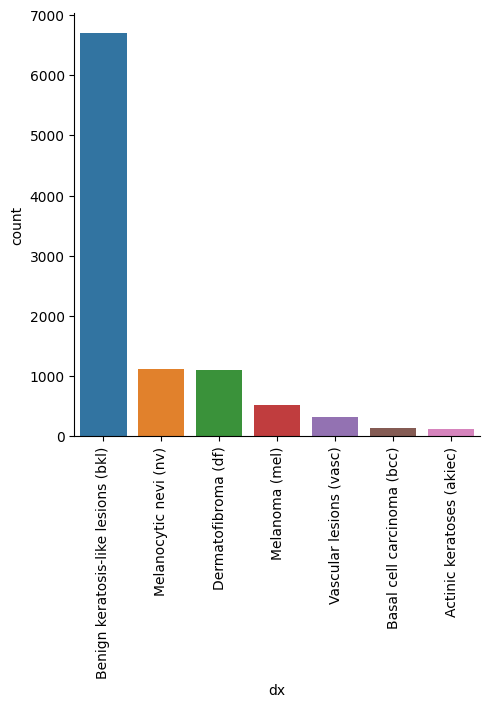

In [ ]:
g = sns.catplot(data = df, x = 'dx', kind = 'count')
g.set_xticklabels(sc_cat, rotation = 90)
plt.show()

Text(0.5, 1.0, 'Age Distribution')

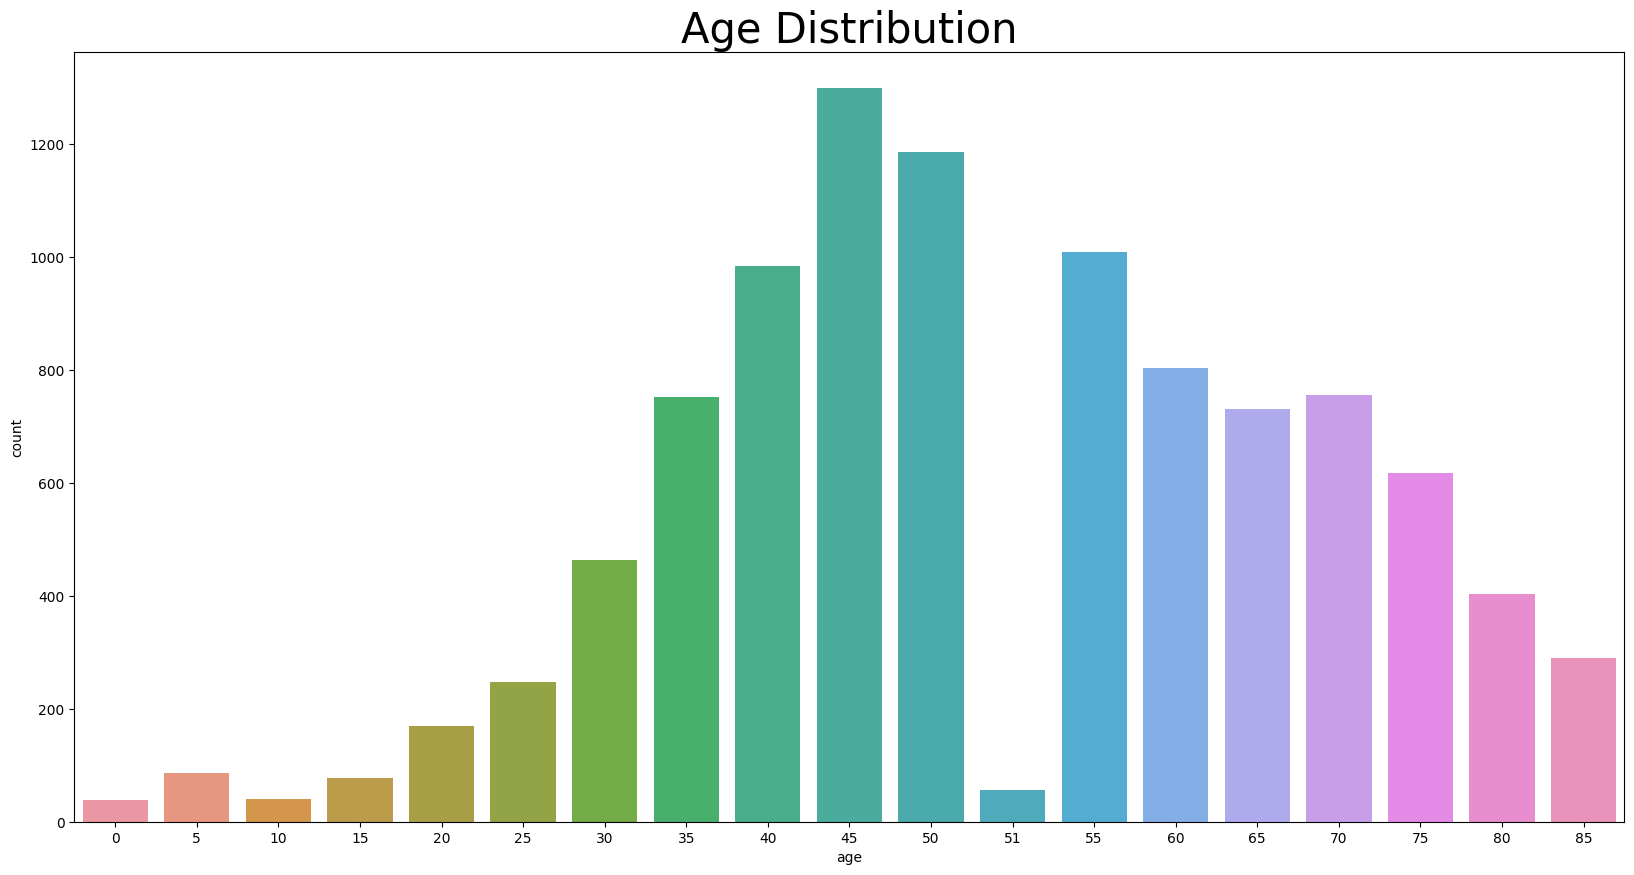

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
a = sns.countplot(data = df, x = 'age')
a.set_title('Age Distribution', fontsize = 30)
plt.show()

Text(0.5, 1.0, 'Connection between age and disease')

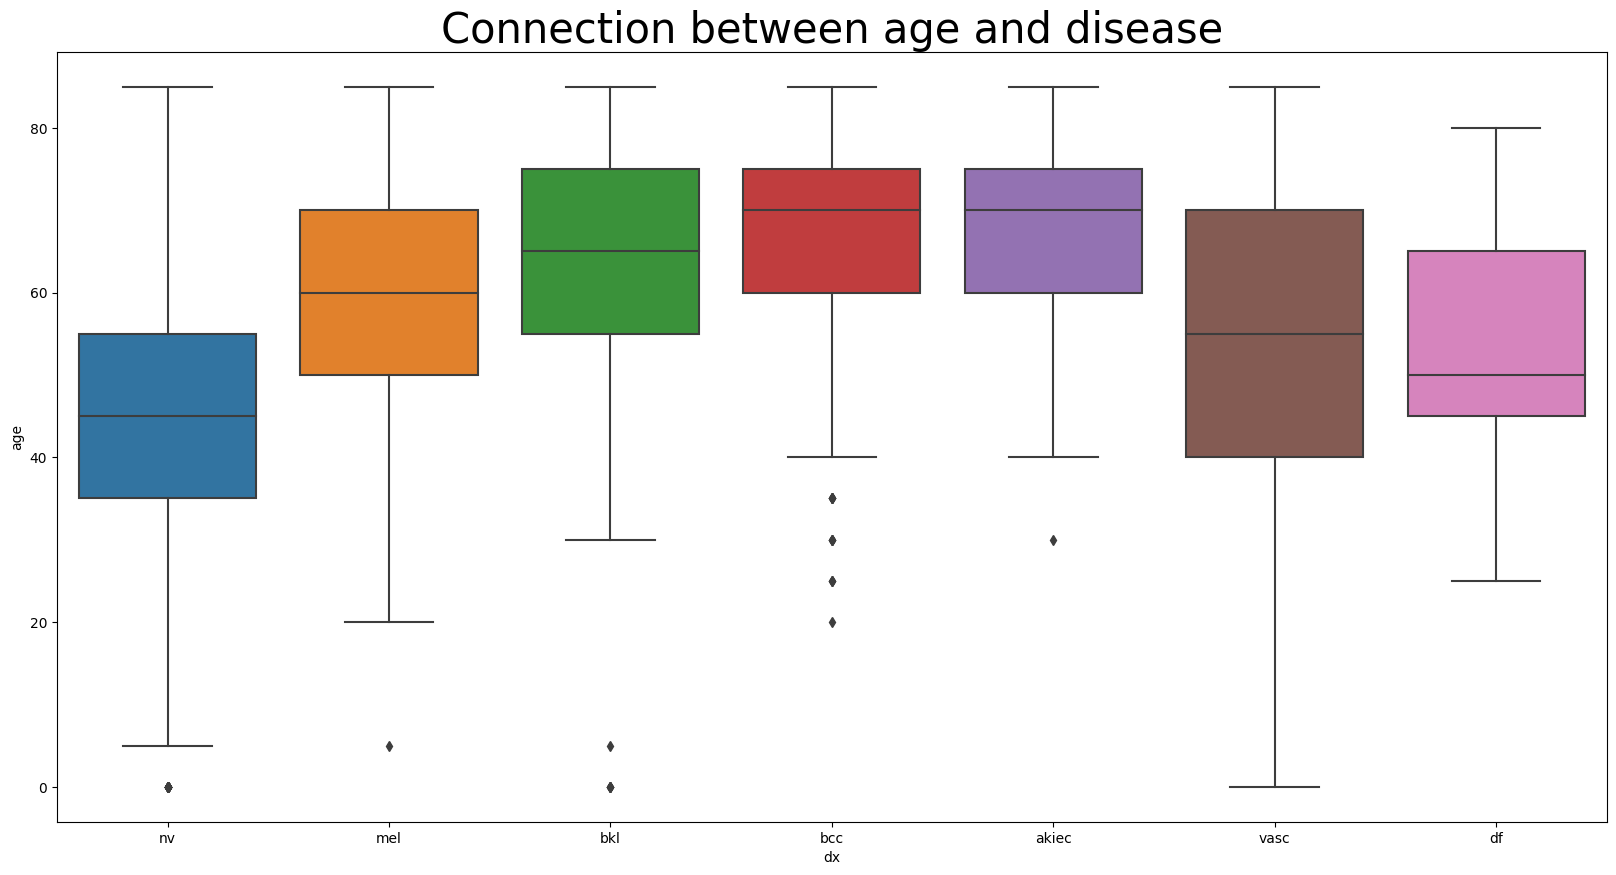

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
g = sns.boxplot(data = df, x = 'dx', y = 'age')
g.set_title('Connection between age and disease', fontsize = 30)
plt.show()

Text(0.5, 1.0, 'Localisation of diseases')

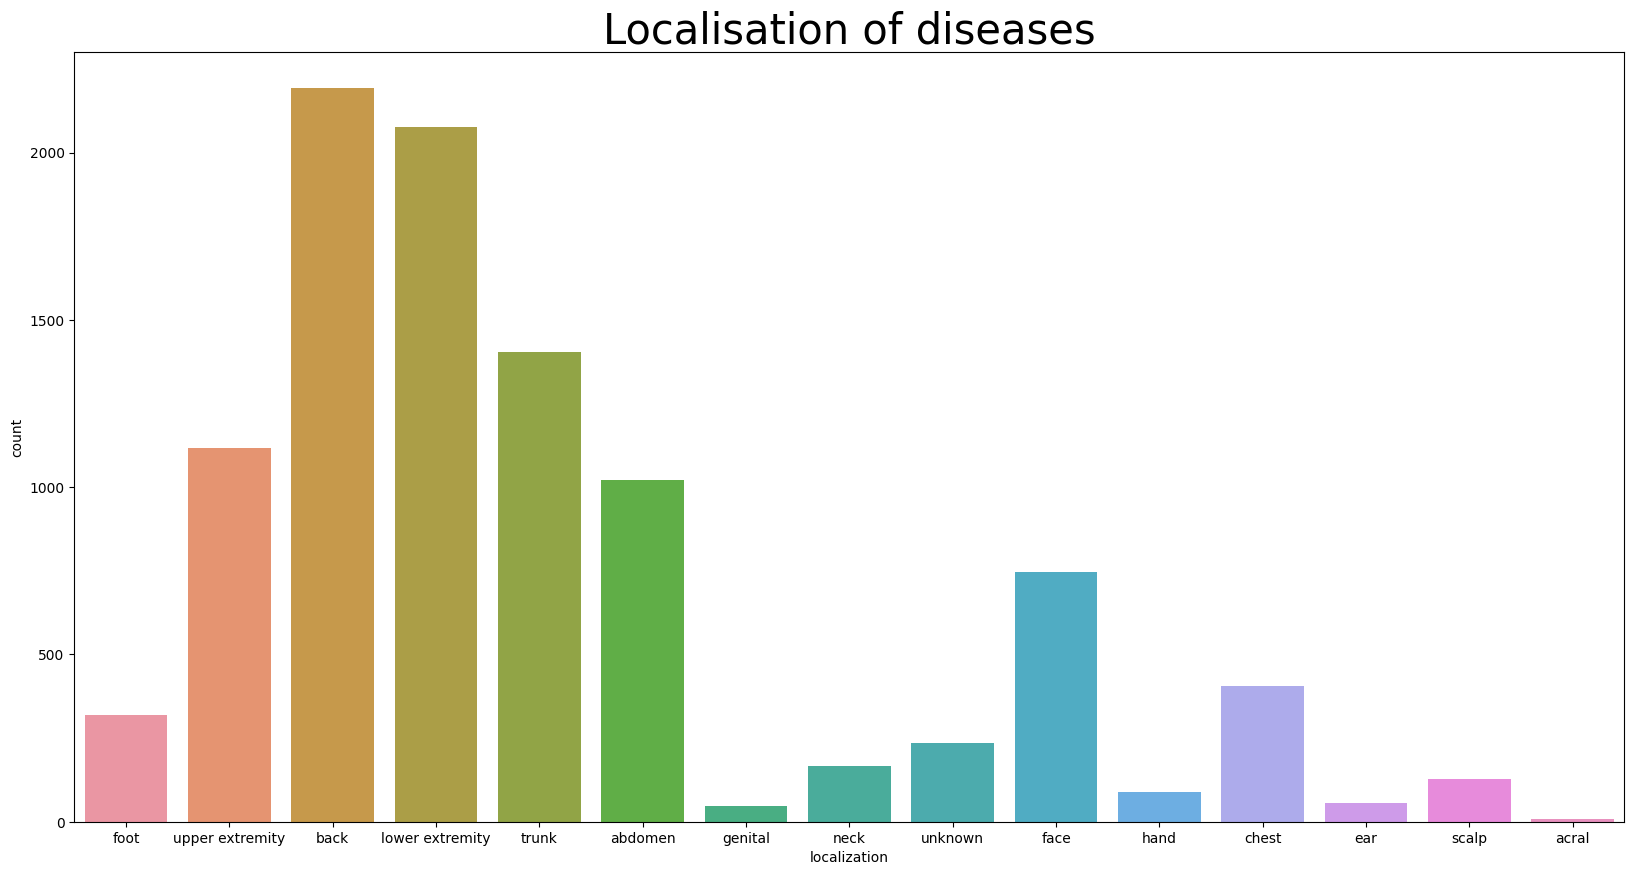

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
l = sns.countplot(data = df, x = 'localization')
l.set_title('Localisation of diseases', fontsize = 30)
plt.show()

Text(0.5, 1.0, 'Localisation of diseases')

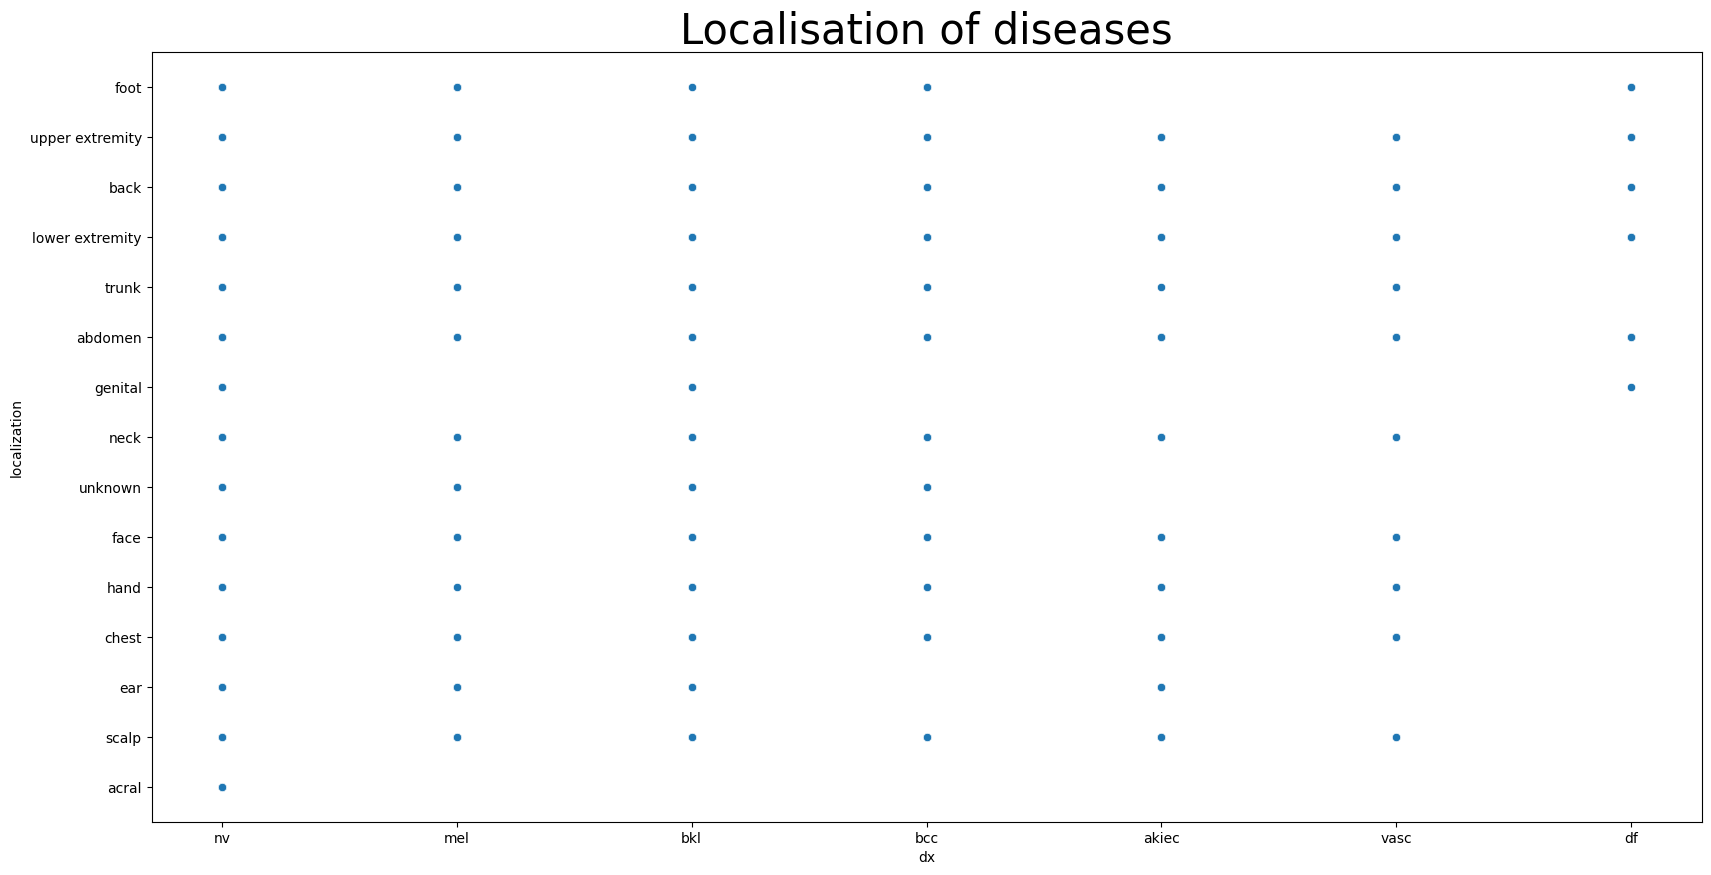

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
l = sns.scatterplot(data = df, x = 'dx', y = 'localization')
l.set_title('Localisation of diseases', fontsize = 30)
plt.show()

# Preparing Train-Test Splits

In [ ]:
def split_into_train_test(X, Y):
    # Split the data into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

    # Prepare data for training and testing the model
    gendata_train = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  width_shift_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    gendata_train.fit(X_train)
    gendata_train = ImageDataGenerator(rescale = 1./255)
    gendata_train.fit(X_test)
    return X_train, X_test, Y_train, Y_test

# Model Preparation

In [ ]:
def prepare_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;


In [ ]:
def model_train(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
                           mode='auto')


    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3,
                              verbose=1, mode='auto')

    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

# **K-Fold Cross Validation**

In [ ]:
def kfolds (X_train,X_test,Y_train,Y_test,folds,epochs):
    INPUTS = np.concatenate((X_train, X_test), axis=0)
    OUTPUTS = np.concatenate((Y_train, Y_test), axis=0)
    per_fold_accuracy=[]
    per_fold_loss =[]
    kfold = StratifiedKFold(n_splits=folds, shuffle=True)
    fold_no=1
    for train,test in kfold.split(INPUTS,OUTPUTS):
        model=prepare_model()
        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        history = model_train(model, INPUTS[train], OUTPUTS[train],EPOCHS=epochs)
        plot_model_training_curve(history)
        # Generate generalization metrics
        scores = model.evaluate(INPUTS[test], OUTPUTS[test], verbose=0)
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        per_fold_accuracy.append(scores[1] * 100)
        per_fold_loss.append(scores[0])
        model_file='skin_caner_5folds_'+str(fold_no)+'.h5'
        model.save(model_file)
        # Increase fold number
        fold_no = fold_no + 1
    return per_fold_accuracy,per_fold_loss

In [ ]:
def get_avg(per_fold_accuracy,per_fold_loss):
    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')

# Testing the Model

In [ ]:
def testing_the_model(model, X_test, Y_test):
    model_accuracy = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_accuracy * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)

    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show()
    return y_true, y_pred

In [ ]:
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'],
            name='train_acc'),
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'],
            name='val_acc'),
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'],
            name='train_loss'),
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'],
            name='val_loss'),
        row=1, col=2)
    fig.show()

# Data Preprocessing

In [ ]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 28, 28, 3)
(10015, 1)


In [ ]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 28, 28, 3)
(45756, 1)


In [ ]:
# For Original Dataset
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = split_into_train_test(X_orig, Y_orig)

In [ ]:
acc_per_fold, loss_per_fold= kfolds(X_train_orig,X_test_orig,Y_train_orig,Y_test_orig,8,50)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 64)          0

Score for fold 1: loss of 0.7300822734832764; accuracy of 75.07987022399902%
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 64)          18496     
                                           

Score for fold 2: loss of 0.6592879891395569; accuracy of 74.60063695907593%
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 7, 64)          18496     
                                           

Score for fold 3: loss of 0.6791634559631348; accuracy of 75.63897967338562%
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 64)          18496     
                                           

Score for fold 4: loss of 0.7117477059364319; accuracy of 74.68051314353943%
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 7, 7, 64)          18496     
                                           

Score for fold 5: loss of 0.6924235224723816; accuracy of 74.92012977600098%
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 7, 7, 64)          18496     
                                           

Score for fold 6: loss of 0.6948978304862976; accuracy of 75.95846652984619%
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 7, 7, 64)          18496     
                                           

Score for fold 7: loss of 0.7599695920944214; accuracy of 74.76038336753845%
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 7, 7, 64)          18496     
                                           

Score for fold 8: loss of 0.754840075969696; accuracy of 73.70104193687439%


In [ ]:
get_avg(acc_per_fold,loss_per_fold)

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.7300822734832764 - Accuracy: 75.07987022399902%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.6592879891395569 - Accuracy: 74.60063695907593%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.6791634559631348 - Accuracy: 75.63897967338562%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.7117477059364319 - Accuracy: 74.68051314353943%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.6924235224723816 - Accuracy: 74.92012977600098%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.6948978304862976 - Accuracy: 75.95846652984619%
------------------------------------------------------------------------

In [ ]:
model =prepare_model()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 4, 4, 64)         

In [ ]:
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = split_into_train_test(X_aug, Y_aug)

In [ ]:
acc_per_fold, loss_per_fold= kfolds(X_train_aug,X_test_aug,Y_train_aug,Y_test_aug,5,50)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 4, 4, 64)         

Score for fold 1: loss of 0.10170985013246536; accuracy of 97.73820042610168%
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 7, 7, 64)          18496     
                                         

Score for fold 2: loss of 0.06086600944399834; accuracy of 98.50289821624756%
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 7, 7, 64)          18496     
                                         

Score for fold 3: loss of 0.08572017401456833; accuracy of 98.07671308517456%
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 7, 7, 64)          18496     
                                         

In [ ]:
get_avg(acc_per_fold,loss_per_fold)

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.10170985013246536 - Accuracy: 97.73820042610168%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.06086600944399834 - Accuracy: 98.50289821624756%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.08572017401456833 - Accuracy: 98.07671308517456%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.0849326029419899 - Accuracy: 97.90186882019043%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.07901112735271454 - Accuracy: 98.28433990478516%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 98.10080409049988 (+- 0.27092512501863947)
> Loss: 0.0824479527771473
-----------------------

In [ ]:
model2_history = model_train(model, X_train_aug, Y_train_aug, 50)

Epoch 1/50
458/458 [==============================] - 40s 84ms/step - loss: 1.5294 - accuracy: 0.4787 - val_loss: 0.9963 - val_accuracy: 0.5864 - lr: 0.0010
Epoch 2/50
458/458 [==============================] - 37s 81ms/step - loss: 0.8016 - accuracy: 0.6905 - val_loss: 0.6897 - val_accuracy: 0.7357 - lr: 0.0010
Epoch 3/50
458/458 [==============================] - 39s 86ms/step - loss: 0.5882 - accuracy: 0.7758 - val_loss: 0.5249 - val_accuracy: 0.7998 - lr: 0.0010
Epoch 4/50
458/458 [==============================] - 37s 80ms/step - loss: 0.4447 - accuracy: 0.8321 - val_loss: 0.4405 - val_accuracy: 0.8306 - lr: 0.0010
Epoch 5/50
458/458 [==============================] - 42s 91ms/step - loss: 0.3450 - accuracy: 0.8686 - val_loss: 0.3190 - val_accuracy: 0.8840 - lr: 0.0010
Epoch 6/50
458/458 [==============================] - 37s 80ms/step - loss: 0.2877 - accuracy: 0.8925 - val_loss: 0.2942 - val_accuracy: 0.8969 - lr: 0.0010
Epoch 7/50
458/458 [==============================] - 37s 

In [ ]:
model

# Confusion Matrix

In [ ]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name, y_true,y_pred):
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = y_pred,y_true

    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Plot the confusion matrix
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

#     b, t = plt.ylim()
#     b += 0.5
#     t -= 0.5
#     plt.ylim(b, t)

    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt

In [ ]:
model.save('Skin_Cancer.h5')

In [ ]:
from IPython.display import FileLink
FileLink('Skin_Cancer.h5')

/content/Skin_Cancer.h5

In [ ]:
model.save_weights("Skin_Cancer.hdf5")

In [ ]:
from IPython.display import FileLink
FileLink('Skin_Cancer.hdf5')

/content/Skin_Cancer.hdf5

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred  = model.predict(X_test_orig).round()

63/63 [==============================] - 1s 12ms/step


In [ ]:

one_picture_predict_data = data.iloc[2]
print(one_picture_predict_data)
print(one_picture_predict_data.dx)
#print(one_picture_predict_data.image_pixel)
y_value = reverse_label_mapping.get(one_picture_predict_data.dx)
print(y_value)


one_picture_predict_data.image_pixel.shape
new_one = one_picture_predict_data.image_pixel.reshape((1,28,28,3))
model.predict(new_one)

index                                                        4477
lesion_id                                             HAM_0002093
image_id                                             ISIC_0027032
dx                                                             nv
dx_type                                                 follow_up
age                                                            45
sex                                                        female
localization                                                 back
cell_type                                   Melanocytic nevi (nv)
path            /content/drive/MyDrive/Final_Project/archive/H...
image_pixel     [[[234, 134, 155], [238, 140, 164], [234, 130,...
label                                                           0
l_id                                                            1
Name: 2, dtype: object
nv
0


(28, 28, 3)

1/1 [==============================] - 0s 112ms/step


array([[9.9999988e-01, 4.4842480e-10, 1.6610949e-07, 1.6526229e-25,
        8.3700565e-22, 8.1038019e-25, 1.0275759e-15]], dtype=float32)

In [ ]:

print(data.iloc[2].path)
im = np.asarray(Image.open(data.iloc[2].path))
im.shape
im = im.reshape((1,450,600,3))
im.shape
new_one = one_picture_predict_data.image_pixel.reshape((1,28,28,3))
model.predict(new_one)

/content/drive/MyDrive/Final_Project/archive/HAM10000_images/ISIC_0027032.jpg


(450, 600, 3)

(1, 450, 600, 3)

1/1 [==============================] - 0s 113ms/step


array([[9.9999988e-01, 4.4842480e-10, 1.6610949e-07, 1.6526229e-25,
        8.3700565e-22, 8.1038019e-25, 1.0275759e-15]], dtype=float32)

Test Accuracy: 97.924%
286/286 [==============================] - 3s 12ms/step
              precision    recall  f1-score   support

          nv       0.99      0.87      0.93      1385
         mel       0.94      0.99      0.97      1328
         bkl       0.95      1.00      0.97      1294
         bcc       0.99      1.00      1.00      1325
       akiec       1.00      1.00      1.00      1270
        vasc       1.00      1.00      1.00      1293
          df       1.00      1.00      1.00      1257

    accuracy                           0.98      9152
   macro avg       0.98      0.98      0.98      9152
weighted avg       0.98      0.98      0.98      9152



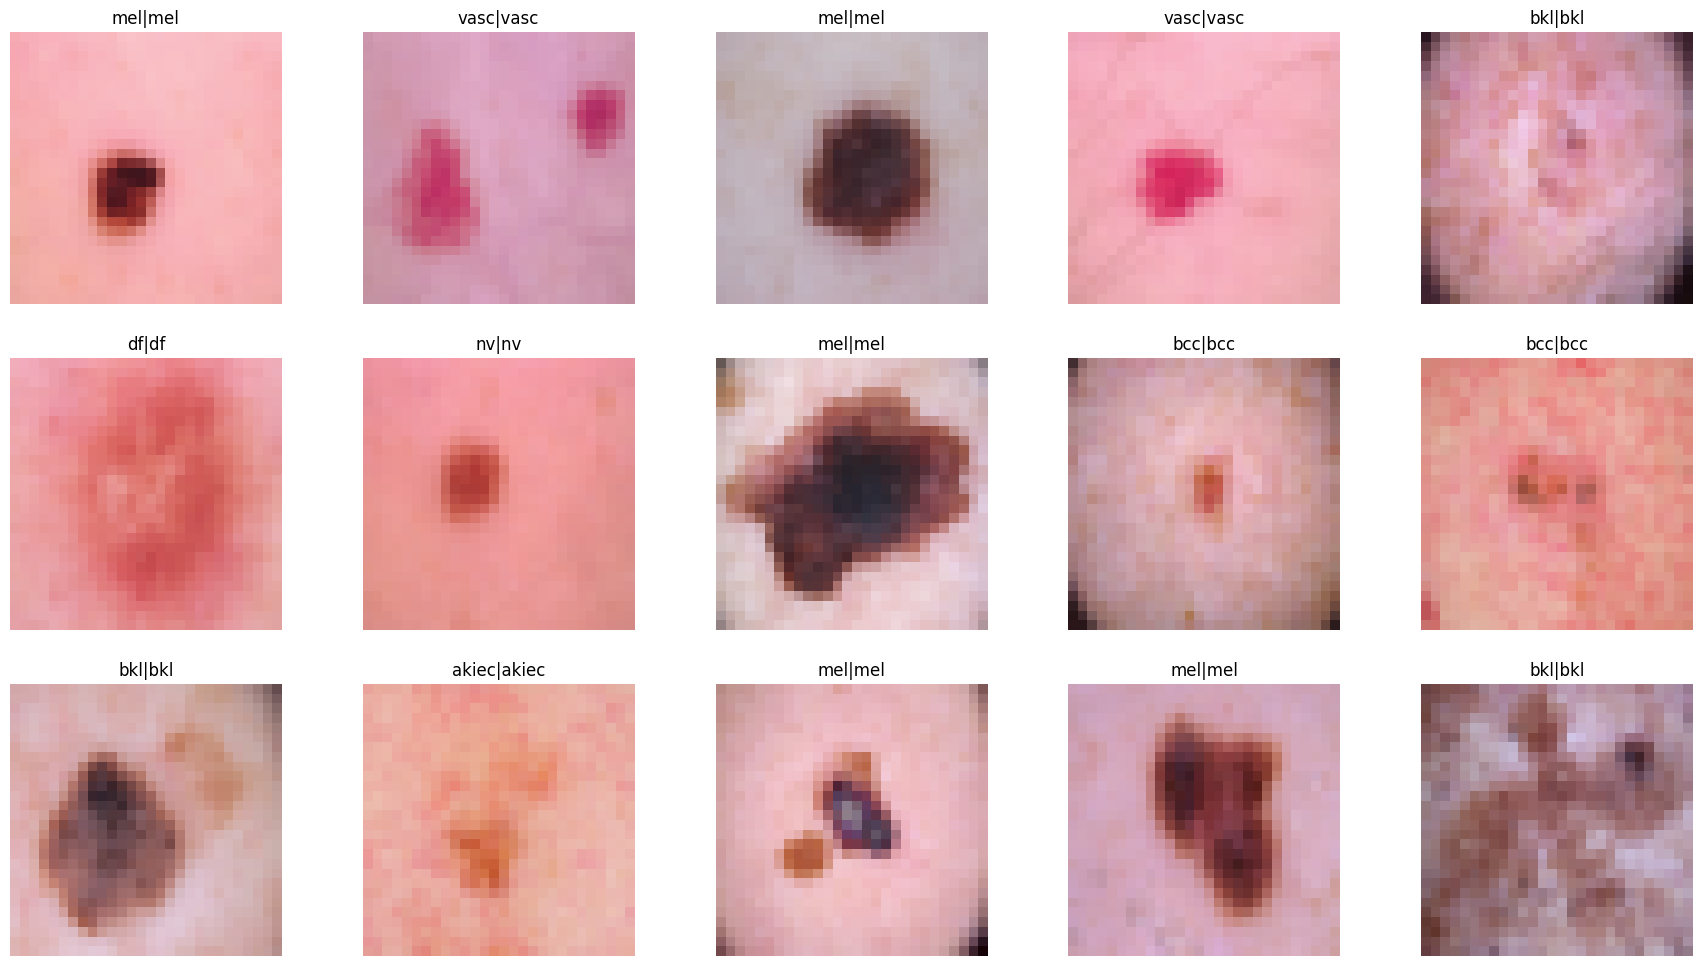

In [ ]:
y_true_aug, y_pred_aug = testing_the_model(model, X_test_aug,Y_test_aug)

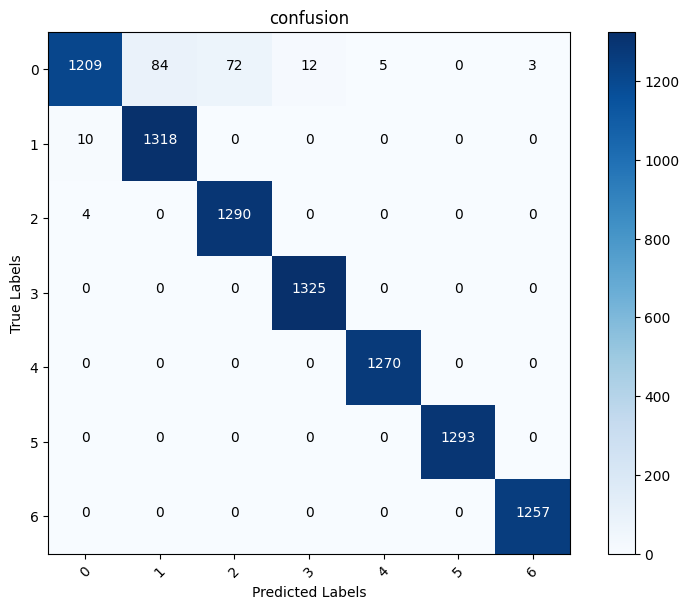

In [ ]:
 create_confusion_matrix(model, X_test_aug, Y_test_aug, label_mapping, 'confusion', y_true_aug, y_pred_aug)